# LSTM models for multivariate Time Series forecastings

## Sommaire

- [I. Préparation des données](#present_data)

- [II. Construction de 2 models LSTM](#LSTM)
    - [II.A LSTM avec des TS non stationarisées](#LSTMA)
    - [II.B LSTM avec des TS stationarisées](#LSTMB)


In [1]:
rm(list=ls())
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

<div id="present_data">

# I . Data preparation

In [2]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2

In [3]:
require(tensorflow)
require(keras)

Loading required package: tensorflow

Loading required package: keras



In [4]:
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
colnames(df.ts) <-lab.to.num$num

In [5]:
df.train <-df.ts %>% as.data.frame

In [6]:
#-----------------------------
# Scaled the train sample and get the sample factor parmas: mean + sd
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))

In [7]:
#----------------
# We d like to do a 6 Quarter forecast,
# We need to base each prediction on 6 points
prediction <- 6
lag <- prediction

In [8]:

x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

In [9]:
cat("Shape de  X_train :",x_train_data%>% dim)

Shape de  X_train : 29 156

In [10]:
x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)


In [11]:
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)

In [12]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test[,1]

In [13]:
x_test

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [14]:
x_pred_arr <- array(
    data=x_test,
    dim=c(1,lag,1)
)

In [15]:
cat("\nX test scaled :",x_test_scaled)


X test scaled : -1.431074 -1.472877 -1.584354 -1.667961 -1.849109 -1.904847

<hr>

<div id="LSTM">

# II. Construct LSTM models

<hr>

## II.A . Construct LSTM model for evaluation : LSTM stable and LSTM non stable

<div id="LSTMA">

## II.A.1 : Evaluation for LSTM model with non stable TS

In [16]:
df.train <-df.ts %>% as.data.frame
#-----------------------------
# Scaled the train sample and get the sample factor parmas: mean + sd
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))
#----------------
# We d like to do a 6 Quarter forecast,
# We need to base each prediction on 6 points
prediction <- 6
lag <- prediction

In [17]:

x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}
x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)
x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(29-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+29-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array
y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array
cat("X_train interval :",1:(dim(scaled_train)[1]-lag-prediction +1),
"\nY_train interval :",
(1+lag):(dim(scaled_train)[1]-prediction +1))
cat("\nx_train dim :",x_train_arr_bis%>%dim,"\nY_train dim :",y_train_arr_bis%>%dim)


X_train interval : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Y_train interval : 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
x_train dim : 29 6 26 
Y_train dim : 29 6 26

In [18]:
LSTM_model_nonstable_eval <- keras_model_sequential()

LSTM_model_nonstable_eval%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

Loaded Tensorflow version 2.9.1



In [19]:
LSTM_model_nonstable_eval %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model_nonstable_eval)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 6, 50)                      15400       
 dropout_1 (Dropout)                (1, 6, 50)                      0           
 lstm (LSTM)                        (1, 6, 50)                      20200       
 dropout (Dropout)                  (1, 6, 50)                      0           
 time_distributed (TimeDistributed)  (1, 6, 26)                     1326        
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [20]:
x_test <-df.train[(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)


,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29,-0.5532000,-0.3471039,0.02739667,-0.7566721,-0.4450734,0.49386289,0.4285909,0.8598923,0.5147032,-0.2130132,⋯,-0.81679252,0.9038091,0.1220994,-1.5207512,1.32128117,-1.1985265,-0.3438949,-0.95537249,-0.2784379,0.03027924
30,-0.6786105,-0.3471039,0.02739667,-1.0153634,-0.3778079,0.05487365,1.4272492,0.4798294,0.5533301,-0.3574289,⋯,-0.95426111,0.4051558,-0.3662981,-1.5207512,1.85334070,-0.5264556,-0.2533963,0.29571053,0.1414288,0.23214080
31,-0.8876281,-0.4122878,0.02739667,-1.0153634,-1.1177284,-0.82310482,1.2608061,0.4798294,0.7464646,-0.2130132,⋯,0.09966473,-0.5921508,-0.3662981,-1.5207512,0.25716211,-0.5264556,-0.7963882,-1.44822338,-0.2010941,1.03958708
32,-1.0687767,-0.4122878,0.57533001,-1.0153634,-0.8038227,-0.82310482,1.1775846,0.4798294,0.8237183,-0.3574289,⋯,-1.00008397,0.1558292,-0.8546956,-1.5207512,-0.09754425,-1.6465738,-1.0226349,0.56109178,-0.6872555,1.03958708
33,-1.1941873,-0.4122878,0.02739667,-0.7566721,-1.0953066,0.49386289,1.2608061,0.0997665,1.0941065,-0.7906759,⋯,-1.04590683,0.4051558,-0.3662981,-0.4719573,-1.51636967,-1.1985265,-1.6561256,-0.87954928,-1.0850240,0.43400237
34,-1.2359908,-0.4774716,0.02739667,-0.4979808,-1.1849939,-0.38411558,1.1775846,0.4798294,1.0554796,-0.7906759,⋯,-0.95426111,-0.8414774,-1.8314906,-0.4719573,-0.98431013,-1.4225501,-1.7013749,-0.04549393,-1.2728591,0.83772551


In [21]:
y_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(y_test)){
    y_test[,i] <-(y_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
y_test_scaled <- y_test
y_test_scaled
y_test_array <- array(
    data = as.numeric(unlist(y_test_scaled)),
    dim=c(1,6,26)
)
cat("\ntime interval taken into X_test:",(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction))
cat("\ntime interval taken into Y_test:", (nrow(scaled_train)- prediction+1):nrow(scaled_train))


,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480



time interval taken into X_test: 29 30 31 32 33 34
time interval taken into Y_test: 35 36 37 38 39 40

In [22]:
history <-LSTM_model_nonstable_eval %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=40,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE,
    validation_data=list(x_test_array,y_test_array)
)

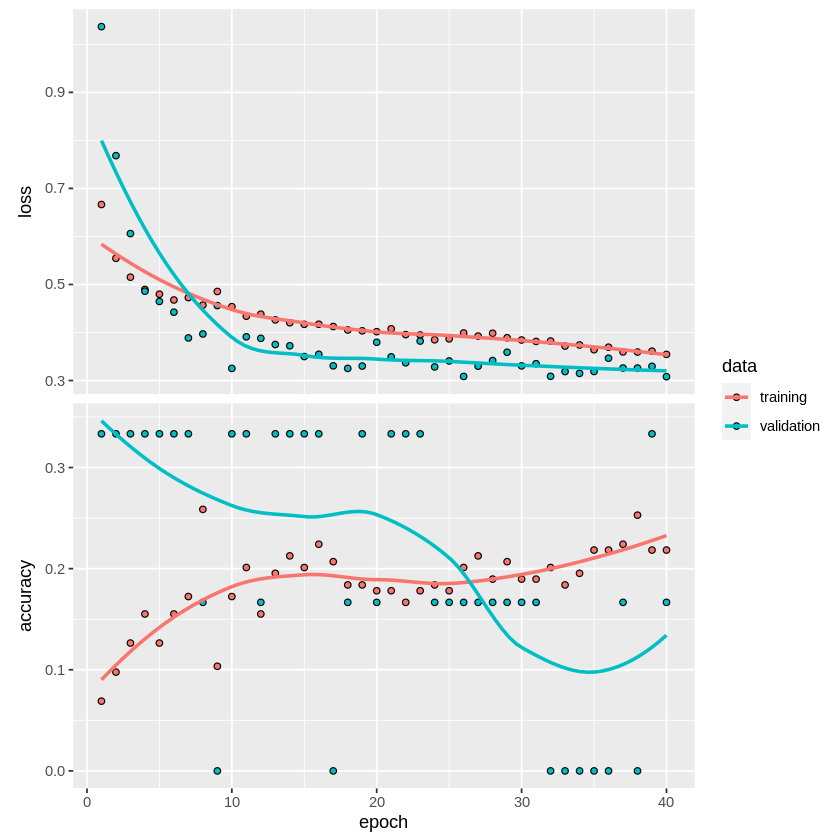

In [23]:
plot(history)

In [24]:
LSTM_model_nonstable_eval %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=40,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [25]:
LSTM_forecast_eval_nonstable <- LSTM_model_nonstable_eval %>% predict(x_test_array,batch_size=1)

In [26]:
#-------------------------
# Unscale predictions
for (i in 1: dim(LSTM_forecast_eval_nonstable)[3]){
    LSTM_forecast_eval_nonstable[,,i] <- LSTM_forecast_eval_nonstable[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}

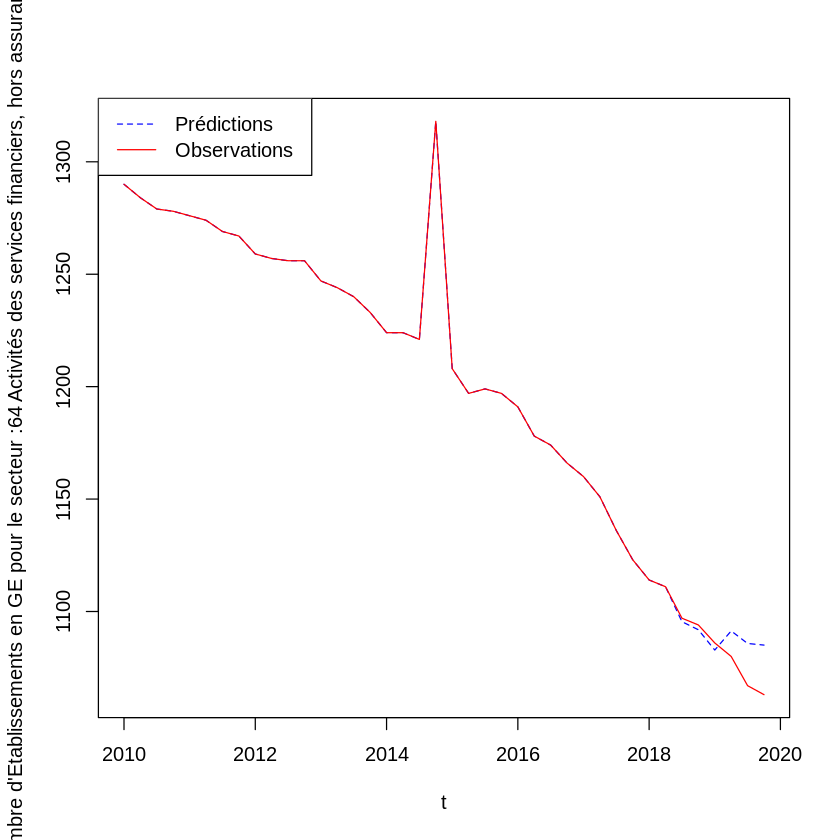

In [27]:
index_secteur <- 1
pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_nonstable[,,index_secteur])
pred <-ts(pred, start=c(2010,1),frequency=4)
obs <- df.ts[,index_secteur]

plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(2,1),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(2,1),
    lwd=1
)

In [378]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_non_stable/test_model/",index_secteur,".png",sep=""))
    pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_nonstable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

        col=c("blue","red")
    )
    legend("topleft",

        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
    )
    dev.off()
}

In [122]:
#----------------------
#Save model
#save_model_tf(LSTM_model,"models/LSTM_non_stable")

<hr>

### Analyse des ecarts entre test et prediction *RMSE, MAE,MAPE,sMAPE*

In [33]:
RMSE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_nonstable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    RMSE <-c(RMSE,sqrt(mean((obs-pred)^2)))
}
RMSE <- RMSE %>% as.data.frame()
colnames(RMSE) <- "RMSE"

In [36]:
MAE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_nonstable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    MAE <-c(MAE,mean(abs(obs-pred)))
    
}
MAE <- MAE %>%as.data.frame()
colnames(MAE) <- "MAE"

In [51]:
MAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_nonstable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    
    MAPE <-c(MAPE,mean(abs((obs-pred)*100/obs)))
    
}
MAPE <- MAPE %>%as.data.frame()
colnames(MAPE) <- "MAPE"

In [52]:
sMAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_nonstable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    sMAPE <-c(sMAPE,mean(200*abs(obs-pred)/(obs+pred)))
    
}
sMAPE <- sMAPE %>%as.data.frame()
colnames(sMAPE) <- "sMAPE"

In [86]:
predict_accuracy_nonstable <- cbind("secteurs"=lab.to.num$lab,RMSE,MAE,MAPE,sMAPE)
predict_accuracy_nonstable

secteurs,RMSE,MAE,MAPE,sMAPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
"64 Activités des services financiers, hors assurance et",3.61067661,3.31477521,0.3073121,0.3067505
65-66 Assurance ; Activités auxiliaires de services fin,4.25867136,3.60336069,0.9399463,0.9437571
852 Enseignement primaire,1.61231390,0.89687286,1.2412261,1.2663834
853 Enseignement secondaire,0.72944453,0.61050086,0.4181439,0.4193450
85x Enseignement / Autre,17.62592902,14.79338920,1.3932661,1.3796888
861 Activités hospitalières,0.78893859,0.74391049,0.7673666,0.7659131
862 Activité des médecins et des dentistes,2.32091763,1.87370109,1.0484998,1.0561280
869 Autres activités pour la santé humaine,2.90865655,2.73328015,1.9625830,1.9845359
87 Hébergement médico-social et social,2.20258441,2.16375069,0.2205194,0.2207714


<hr>

## II.A.2 Evaluation : LSTM model with stable TS

In [61]:
df.diff <-diff(df.ts)
df.train <-df.diff%>%as.data.frame
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))
prediction <- 6
lag <- prediction

In [62]:
x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)

y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)
cat("X_train interval :",1:(dim(scaled_train)[1]-lag-prediction +1),
"\nY_train interval :",
(1+lag):(dim(scaled_train)[1]-prediction +1))

# Expected :  X_train 1:28, Y_train 7:34


X_train interval : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Y_train interval : 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34

In [63]:
x_train_arr %>%dim
y_train_arr%>%dim

[1]  28 156   1

[1] 28  6  1

In [65]:
#--------------------------------
# Restructur data inputs for LSTM multivariate

x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(28-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+28-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array


y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array
x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 28  6 26

[1] 28  6 26

In [66]:
LSTM_model_stable_eval <- keras_model_sequential()
LSTM_model_stable_eval%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))


In [67]:
LSTM_model_stable_eval %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model_stable_eval)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_3 (LSTM)                      (1, 6, 50)                      15400       
 dropout_3 (Dropout)                (1, 6, 50)                      0           
 lstm_2 (LSTM)                      (1, 6, 50)                      20200       
 dropout_2 (Dropout)                (1, 6, 50)                      0           
 time_distributed_1 (TimeDistribute  (1, 6, 26)                     1326        
 d)                                                                             
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [69]:
x_test <-df.train[(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
print(" X_test")
x_test_scaled
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)
y_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(y_test)){
    y_test[,i] <-(y_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
y_test_scaled <- y_test
print("Y_test")
y_test_scaled
y_test_array <- array(
    data = as.numeric(unlist(y_test_scaled)),
    dim=c(1,6,26)
)
cat("\ntime interval taken into X_test:",(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction))
cat("\ntime interval taken into Y_test:", (nrow(scaled_train)- prediction+1):nrow(scaled_train))

[1] " X_test"


,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,-0.007441709,-0.16319405,0.87008959,-0.4029005,-1.50567174,0.57844364,0.92985654,-1.3814269,1.05174586,0.5548215,⋯,0.004506226,-1.4100094,0.06999538,0.0588068,1.4724125,-0.78444517,-1.79277629,-0.9185998,-0.8988872,-0.7570491
29,-0.131824555,-0.05346012,-0.07250747,-0.4029005,0.22257756,-0.67485091,2.59992783,-1.3814269,-0.35298320,-0.2044079,⋯,-0.083365181,-0.4779693,-0.61245961,0.0588068,0.9357388,1.31099056,0.65060430,1.0051228,1.2456847,0.2437955
30,-0.380590246,-0.16319405,-0.07250747,0.1389312,-1.19144460,-1.30149818,-0.74021475,-0.2228108,0.77080005,0.5548215,⋯,1.058963107,-0.9439893,0.06999538,0.0588068,-2.2843034,0.05372912,-1.98072864,-1.4862556,-0.7273215,1.7450622
31,-0.297668349,-0.05346012,0.87008959,0.1389312,0.65463989,-0.04820364,-0.50163313,-0.2228108,-0.07203739,-0.2044079,⋯,-1.006014951,0.6870808,-0.61245961,0.0588068,-0.4059455,-2.04170661,-0.66506217,1.6358515,-1.0990473,-0.2566268
32,-0.131824555,-0.05346012,-1.01510452,0.6807629,-0.40587673,1.83173818,-0.02446991,-1.3814269,1.33269168,-0.9636374,⋯,0.004506226,0.2210608,0.75245037,1.7789056,-2.0159666,0.89190341,-2.35663335,-1.2339641,-0.8702929,-1.7578936
33,0.116941137,-0.16319405,-0.07250747,0.6807629,-0.05237119,-1.30149818,-0.50163313,0.9358053,-0.91487483,0.1752068,⋯,0.136313336,-1.1769993,-1.97736959,0.0588068,0.9357388,-0.36535803,0.08674724,0.6582220,-0.3270014,0.7442177


[1] "Y_test"


,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622



time interval taken into X_test: 28 29 30 31 32 33
time interval taken into Y_test: 34 35 36 37 38 39

In [70]:
history <-LSTM_model_stable_eval %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=40,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE,
    validation_data=list(x_test_array,y_test_array)
)

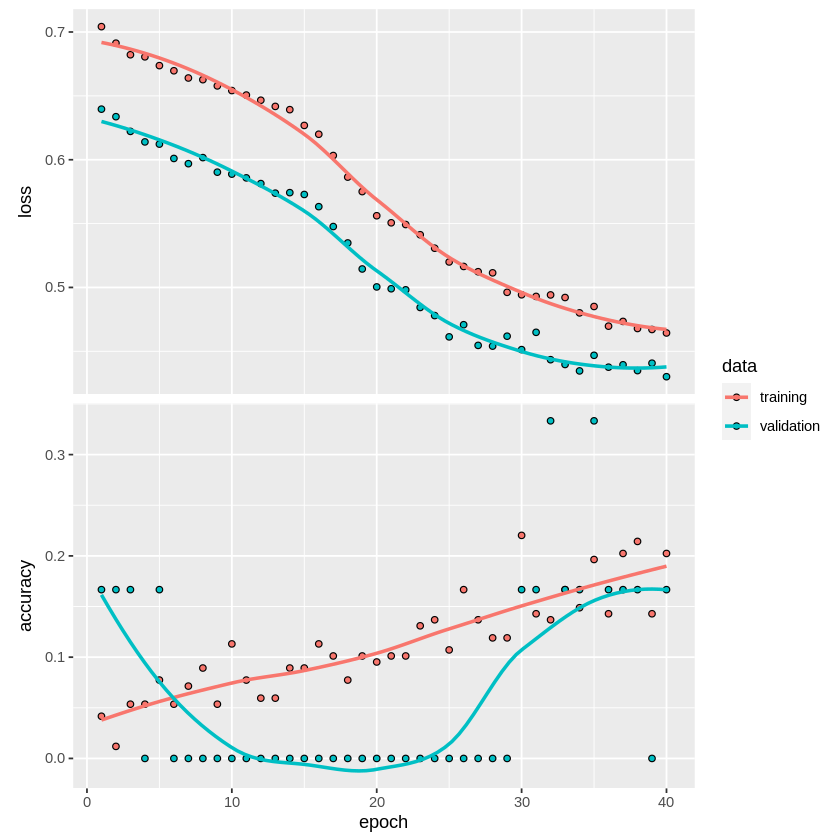

In [71]:
plot(history)

In [72]:
LSTM_model_stable_eval %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=40,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [73]:
LSTM_forecast_eval_stable <- LSTM_model_stable_eval %>% predict(x_test_array,batch_size=1)

In [74]:
#-------------
# 1.unscale Predictions
for (i in 1: dim(LSTM_forecast_eval_stable)[3]){
    LSTM_forecast_eval_stable[,,i] <- LSTM_forecast_eval_stable[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}

In [76]:
index_secteur=1
pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_stable[,,index_secteur])
pred <-ts(pred, start=c(2010,2),frequency=4)
obs <- df.diff[,index_secteur]


#-----------------
# Inverse differenciation
starting_point <- df.ts[1,index_secteur]
obs <-diffinv(obs,xi=starting_point)

obs <-ts(obs, start=c(2010,1),frequency=4)
pred <-diffinv(pred,xi=starting_point)
pred
obs

,Qtr1,Qtr2,Qtr3,Qtr4
2010,1290.000,1284.000,1279.000,1278.000
2011,1276.000,1274.000,1269.000,1267.000
2012,1259.000,1257.000,1256.000,1256.000
2013,1247.000,1244.000,1240.000,1233.000
2014,1224.000,1224.000,1221.000,1318.000
2015,1208.000,1197.000,1199.000,1197.000
2016,1191.000,1178.000,1174.000,1166.000
2017,1160.000,1151.000,1136.000,1123.000
2018,1114.000,1111.000,1101.077,1095.852
2019,1089.015,1081.518,1072.796,1066.632


,Qtr1,Qtr2,Qtr3,Qtr4
2010,1290,1284,1279,1278
2011,1276,1274,1269,1267
2012,1259,1257,1256,1256
2013,1247,1244,1240,1233
2014,1224,1224,1221,1318
2015,1208,1197,1199,1197
2016,1191,1178,1174,1166
2017,1160,1151,1136,1123
2018,1114,1111,1097,1094
2019,1086,1080,1067,1063


In [77]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_stable/test_model/",index_secteur,".png",sep=""))
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]


    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    obs <-ts(obs, start=c(2010,1),frequency=4)

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

        col=c("blue","red")
    )
    legend("topleft",

        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
    )
    dev.off()
}

<hr>

### Analyse des ecarts entre test et prediction *RMSE, MAE,MAPE,sMAPE*

In [80]:
RMSE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    RMSE <-c(RMSE,sqrt(mean((obs-pred)^2)))
}
RMSE <- RMSE %>% as.data.frame()
colnames(RMSE) <- "RMSE"

In [81]:
MAE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_stable)[3]){
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    MAE <-c(MAE,mean(abs(obs-pred)))
    
}
MAE <- MAE %>%as.data.frame()
colnames(MAE) <- "MAE"

In [82]:
MAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    
    MAPE <-c(MAPE,mean(abs((obs-pred)*100/obs)))
    
}
MAPE <- MAPE %>%as.data.frame()
colnames(MAPE) <- "MAPE"

In [83]:
sMAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast_eval_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    sMAPE <-c(sMAPE,mean(200*abs(obs-pred)/(obs+pred)))
    
}
sMAPE <- sMAPE %>%as.data.frame()
colnames(sMAPE) <- "sMAPE"

In [84]:
predict_accuracy_stable <- cbind("secteurs"=lab.to.num$lab,RMSE,MAE,MAPE,sMAPE)
predict_accuracy_stable


secteurs,RMSE,MAE,MAPE,sMAPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
"64 Activités des services financiers, hors assurance et",3.61067661,3.31477521,0.3073121,0.3067505
65-66 Assurance ; Activités auxiliaires de services fin,4.25867136,3.60336069,0.9399463,0.9437571
852 Enseignement primaire,1.61231390,0.89687286,1.2412261,1.2663834
853 Enseignement secondaire,0.72944453,0.61050086,0.4181439,0.4193450
85x Enseignement / Autre,17.62592902,14.79338920,1.3932661,1.3796888
861 Activités hospitalières,0.78893859,0.74391049,0.7673666,0.7659131
862 Activité des médecins et des dentistes,2.32091763,1.87370109,1.0484998,1.0561280
869 Autres activités pour la santé humaine,2.90865655,2.73328015,1.9625830,1.9845359
87 Hébergement médico-social et social,2.20258441,2.16375069,0.2205194,0.2207714


<hr>

## II.B Covid Forecastings

## II.B.1 Covid Forecasting : LSTM model with nonstable TS

In [87]:
df.train <-df.ts %>% as.data.frame
#-----------------------------
# Scaled the train sample and get the sample factor parmas: mean + sd
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))
#----------------
# We d like to do a 6 Quarter forecast,
# We need to base each prediction on 6 points
prediction <- 6
lag <- prediction

In [88]:

x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}
x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)
x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(29-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+29-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array
y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array
cat("X_train interval :",1:(dim(scaled_train)[1]-lag-prediction +1),
"\nY_train interval :",
(1+lag):(dim(scaled_train)[1]-prediction +1))
cat("\nx_train dim :",x_train_arr_bis%>%dim,"\nY_train dim :",y_train_arr_bis%>%dim)

X_train interval : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Y_train interval : 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
x_train dim : 29 6 26 
Y_train dim : 29 6 26

In [91]:
LSTM_model_nonstable_forecasting <- keras_model_sequential()

LSTM_model_nonstable_forecasting%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

In [92]:
LSTM_model_nonstable_forecasting%>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model_nonstable_forecasting)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_7 (LSTM)                      (1, 6, 50)                      15400       
 dropout_7 (Dropout)                (1, 6, 50)                      0           
 lstm_6 (LSTM)                      (1, 6, 50)                      20200       
 dropout_6 (Dropout)                (1, 6, 50)                      0           
 time_distributed_3 (TimeDistribute  (1, 6, 26)                     1326        
 d)                                                                             
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [93]:
LSTM_model_nonstable_forecasting %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=40,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [94]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]

# 2. Scaled 
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
cat("X_test interval :",(nrow(scaled_train)- prediction+1):nrow(scaled_train))
x_test_scaled

X_test interval : 35 36 37 38 39 40

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [95]:
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

In [96]:
#----------------
# Covid forecast
LSTM_forecast_covid_non_stable <- LSTM_model_nonstable_forecasting %>% predict(x_test_array,batch_size=1)

In [97]:
#-------------
# 1.unscale Predictions
for (i in 1: dim(LSTM_forecast_covid_non_stable)[3]){
    LSTM_forecast_covid_non_stable[,,i] <- LSTM_forecast_covid_non_stable[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}

,Qtr1,Qtr2,Qtr3,Qtr4
2010,1290.000,1284.000,1279.000,1278.000
2011,1276.000,1274.000,1269.000,1267.000
2012,1259.000,1257.000,1256.000,1256.000
2013,1247.000,1244.000,1240.000,1233.000
2014,1224.000,1224.000,1221.000,1318.000
2015,1208.000,1197.000,1199.000,1197.000
2016,1191.000,1178.000,1174.000,1166.000
2017,1160.000,1151.000,1136.000,1123.000
2018,1114.000,1111.000,1097.000,1094.000
2019,1086.000,1080.000,1067.000,1063.000


,Qtr1,Qtr2,Qtr3,Qtr4
2010,1290,1284,1279,1278
2011,1276,1274,1269,1267
2012,1259,1257,1256,1256
2013,1247,1244,1240,1233
2014,1224,1224,1221,1318
2015,1208,1197,1199,1197
2016,1191,1178,1174,1166
2017,1160,1151,1136,1123
2018,1114,1111,1097,1094
2019,1086,1080,1067,1063


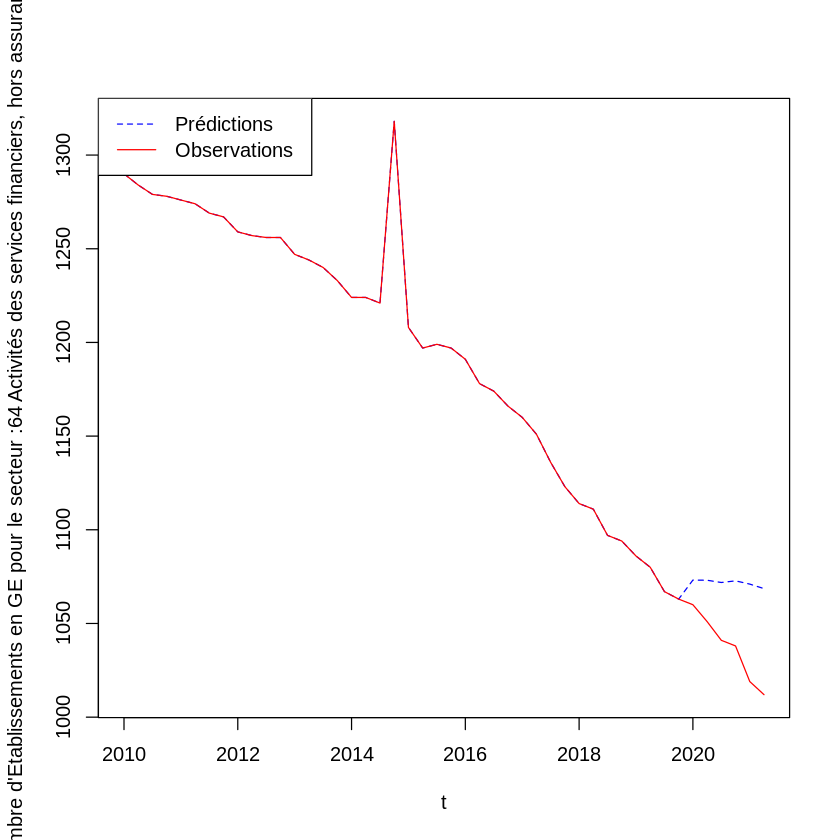

In [100]:
index_secteur=1
pred <- c(df.ts[,index_secteur],LSTM_forecast_covid_non_stable[,,index_secteur])
pred <-ts(pred, start=c(2010,1),frequency=4)
obs <- df.ts[,index_secteur]
obs <-c(obs,covid.ts[,index_secteur])
obs <-ts(obs, start=c(2010,1),frequency=4)
pred
obs
plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(2,1),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(2,1),
    lwd=1
)

In [101]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_non_stable/covid_forecast/",index_secteur,".png",sep=""))
    pred <- c(df.ts[,index_secteur],LSTM_forecast_covid_non_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

        col=c("blue","red")
    )
    legend("topleft",

        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
    )
    dev.off()
}

<hr>

### Analyse des ecarts entre test et prediction *RMSE, MAE,MAPE,sMAPE*

In [103]:
RMSE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[,index_secteur],LSTM_forecast_covid_non_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    RMSE <-c(RMSE,sqrt(mean((obs-pred)^2)))
}
RMSE <- RMSE %>% as.data.frame()
colnames(RMSE) <- "RMSE"


#------------------------------------

MAE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[,index_secteur],LSTM_forecast_covid_non_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    MAE <-c(MAE,mean(abs(obs-pred)))
    
}
MAE <- MAE %>%as.data.frame()
colnames(MAE) <- "MAE"

#------------------------------------


MAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[,index_secteur],LSTM_forecast_covid_non_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    
    MAPE <-c(MAPE,mean(abs((obs-pred)*100/obs)))
    
}
MAPE <- MAPE %>%as.data.frame()
colnames(MAPE) <- "MAPE"

#------------------------------------

sMAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_eval_nonstable)[3]){
    pred <- c(df.ts[,index_secteur],LSTM_forecast_covid_non_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    sMAPE <-c(sMAPE,mean(200*abs(obs-pred)/(obs+pred)))
    
}
sMAPE <- sMAPE %>%as.data.frame()
colnames(sMAPE) <- "sMAPE"

In [104]:
differences_analysis_nonstable <- cbind("secteurs"=lab.to.num$lab,RMSE,MAE,MAPE,sMAPE)
differences_analysis_nonstable 

secteurs,RMSE,MAE,MAPE,sMAPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
"64 Activités des services financiers, hors assurance et",38.1450582,34.9111953,3.3920397,3.3241860
65-66 Assurance ; Activités auxiliaires de services fin,24.9892560,23.6659244,6.7170724,6.4730262
852 Enseignement primaire,2.0400645,1.6316644,2.2641781,2.3046536
853 Enseignement secondaire,0.9100466,0.7965242,0.5504218,0.5490186
85x Enseignement / Autre,38.4874325,29.5706568,2.9406685,2.8699426
861 Activités hospitalières,2.6872236,2.6606309,2.6816090,2.7187593
862 Activité des médecins et des dentistes,4.5352783,3.7401915,2.0783683,2.0791960
869 Autres activités pour la santé humaine,9.3334728,7.8252777,6.1530653,5.8938531
87 Hébergement médico-social et social,12.2240972,10.5113972,1.0563939,1.0639682


<hr>

<div id="LSTMB">

## II.B.2  Covid Forecasting : LSTM model with stable TS

In [105]:
df.diff <-diff(df.ts)
df.train <-df.diff%>%as.data.frame
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))
prediction <- 6
lag <- prediction

In [106]:
x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)

y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)
cat("X_train interval :",1:(dim(scaled_train)[1]-lag-prediction +1),
"\nY_train interval :",
(1+lag):(dim(scaled_train)[1]-prediction +1))


X_train interval : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Y_train interval : 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34

In [107]:
x_train_arr %>%dim
y_train_arr %>%dim

[1]  28 156   1

[1] 28  6  1

In [108]:
#--------------------------------
# Restructur data inputs for LSTM multivariate

x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(28-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+28-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array


y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array

In [109]:
x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 28  6 26

[1] 28  6 26

In [111]:
LSTM_model_stable_forecasting <- keras_model_sequential()

LSTM_model_stable_forecasting %>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

In [112]:
LSTM_model_stable_forecasting %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model_stable_forecasting)

Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_11 (LSTM)                     (1, 6, 50)                      15400       
 dropout_11 (Dropout)               (1, 6, 50)                      0           
 lstm_10 (LSTM)                     (1, 6, 50)                      20200       
 dropout_10 (Dropout)               (1, 6, 50)                      0           
 time_distributed_5 (TimeDistribute  (1, 6, 26)                     1326        
 d)                                                                             
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [113]:
LSTM_model_stable_forecasting %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=40,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [114]:
x_train_arr_bis%>%dim
y_train_arr_bis%>%dim

[1] 28  6 26

[1] 28  6 26

In [115]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
# 1. Differenciate (already)

# 2. Scaled 
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
cat("X_test interval :",(nrow(scaled_train)- prediction+1):nrow(scaled_train))
x_test_scaled


X_test interval : 34 35 36 37 38 39

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622


In [116]:
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

In [121]:
#----------------
# Covid forecast
LSTM_forecast_covid_stable <- LSTM_model_stable_forecasting %>% predict(x_test_array,batch_size=1)

In [122]:
LSTM_forecast_covid_stable[,,1]# Its coherente with the X_test_array_sequence

[1] -0.060120013  0.107662916 -0.012594271  0.134568229 -0.037465509
[6]  0.003151483

In [123]:
#----------------------------------
# Remembering we did 2 operations before inputing datat in our model : 
# 1.Differenciation
# 2. Scaling

#-------------
# 1.unscale Predictions
for (i in 1: dim(LSTM_forecast_covid_stable)[3]){
    LSTM_forecast_covid_stable[,,i] <- LSTM_forecast_covid_stable[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}


In [124]:
index_secteur=1
pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
pred <-ts(pred, start=c(2010,2),frequency=4)
obs <- df.diff[,index_secteur]


#-----------------
# Inverse differenciation
starting_point <- df.ts[1,index_secteur]
obs <-diffinv(obs,xi=starting_point)
obs <-c(obs,covid.ts[,index_secteur])
obs <-ts(obs, start=c(2010,1),frequency=4)
pred <-diffinv(pred,xi=starting_point)
pred
obs


,Qtr1,Qtr2,Qtr3,Qtr4
2010,1290.000,1284.000,1279.000,1278.000
2011,1276.000,1274.000,1269.000,1267.000
2012,1259.000,1257.000,1256.000,1256.000
2013,1247.000,1244.000,1240.000,1233.000
2014,1224.000,1224.000,1221.000,1318.000
2015,1208.000,1197.000,1199.000,1197.000
2016,1191.000,1178.000,1174.000,1166.000
2017,1160.000,1151.000,1136.000,1123.000
2018,1114.000,1111.000,1097.000,1094.000
2019,1086.000,1080.000,1067.000,1063.000


,Qtr1,Qtr2,Qtr3,Qtr4
2010,1290,1284,1279,1278
2011,1276,1274,1269,1267
2012,1259,1257,1256,1256
2013,1247,1244,1240,1233
2014,1224,1224,1221,1318
2015,1208,1197,1199,1197
2016,1191,1178,1174,1166
2017,1160,1151,1136,1123
2018,1114,1111,1097,1094
2019,1086,1080,1067,1063


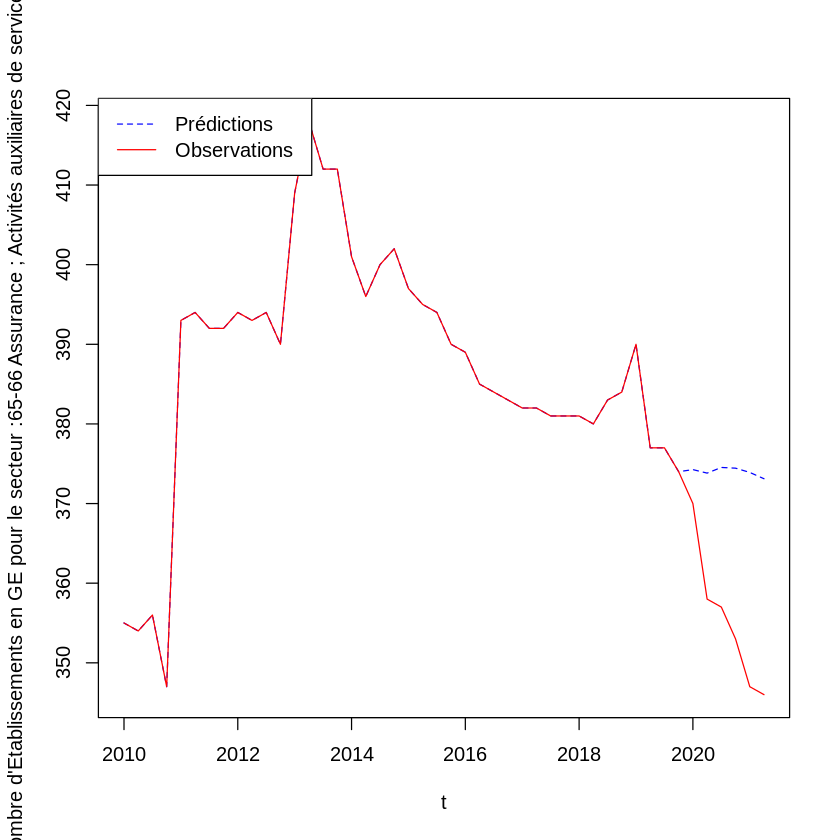

In [125]:
index_secteur <- 2

pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
pred <-ts(pred, start=c(2010,2),frequency=4)
obs <- df.diff[,index_secteur]


#-----------------
# Inverse differenciation
starting_point <- df.ts[1,index_secteur]
obs <-diffinv(obs,xi=starting_point)
obs <-c(obs,covid.ts[,index_secteur])
obs <-ts(obs, start=c(2010,1),frequency=4)
pred <-diffinv(pred,xi=starting_point)
plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(2,1),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(2,1),
    lwd=1
)

In [126]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_stable/covid_forecast/",index_secteur,".png",sep=""))
    pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    
    
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    pred <-diffinv(pred,xi=starting_point)

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        main=paste("Predictions LSTM stable vs observations \n secteur : ",lab.to.num$lab[index_secteur],sep=""),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

    )
    legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
    dev.off()
}

In [342]:
#----------------------
#Save model
#save_model_tf(LSTM_model,"models/LSTM_stable")


<hr>

# Analyse des ecarts remarqué entre ce que l'on a prédit sur la période et ce qu'il en a été sur la période covid

### Calculate RMSE *Residual Mean Square Error*

In [128]:
RMSE <- c()
for (index_secteur in 1:dim(LSTM_forecast_covid_stable)[3]){
    pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    pred <-diffinv(pred,xi=starting_point)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    RMSE <-c(RMSE,sqrt(mean((obs-pred)^2)))
}

In [129]:
RMSE_stable_LSTM <-RMSE %>% as.data.frame()
colnames(RMSE_stable_LSTM) <-"rmse"
RMSE_stable_LSTM


rmse
<dbl>
11.4317314
20.3931039
2.1032881
2.4232995
46.0401394
3.5012284
4.3602732
12.6015309
5.3838871


In [130]:
summary(RMSE_stable_LSTM$rmse)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.6538   3.2111   4.7663  21.2319  11.6600 156.5252 

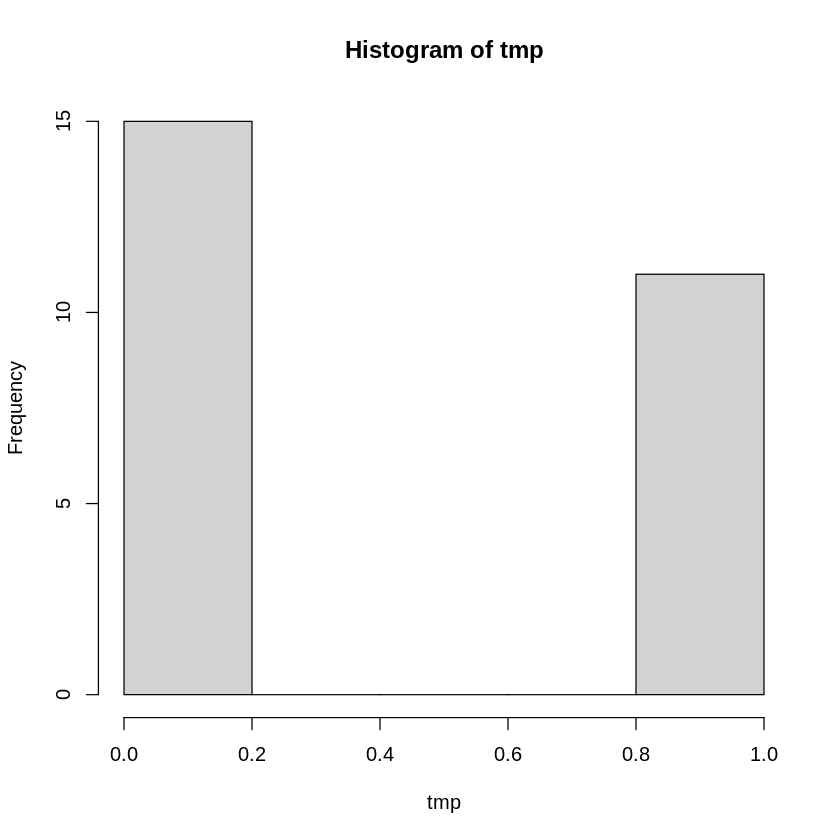

In [131]:
RMSE_stable_LSTM$group <- RMSE_stable_LSTM$rmse >6.92
tmp <-apply(RMSE_stable_LSTM,1,FUN=function(x){if(x[2]){return(1)}else{return(0) }})

hist(tmp)


### Calculate MAE *Mean Absolute Error*

In [132]:
MAE <- c()
for (index_secteur in 1:dim(LSTM_forecast_covid_stable)[3]){
    pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    pred <-diffinv(pred,xi=starting_point)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    
    MAE <-c(MAE,mean(abs(obs-pred)))
    
}
MAE <- MAE %>%as.data.frame()
colnames(MAE) <- "MAE"


In [133]:
summary(MAE)

      MAE          
 Min.   :  0.4766  
 1st Qu.:  2.9129  
 Median :  3.9323  
 Mean   : 18.0084  
 3rd Qu.: 10.6927  
 Max.   :139.0659  

### Calculate MAPE *Mean Absolute  Percentage Error*

**They have the advantage to be unit free.**

Measures based on percentage errors have the disadvantage of being infinite or undefined if yt=0 for any t in the period of interest, and having extreme values if any yt is close to zero. Another problem with percentage errors that is often overlooked is that they assume the unit of measurement has a meaningful zero.2 For example, a percentage error makes no sense when measuring the accuracy of temperature forecasts on either the Fahrenheit or Celsius scales, because temperature has an arbitrary zero point.

**Ceci ne possera pas de probleme si l'on unscale + inv differenciate**

In [134]:
MAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_covid_stable)[3]){
    pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    pred <-diffinv(pred,xi=starting_point)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    
    MAPE <-c(MAPE,mean(abs((obs-pred)*100/obs)))
    
}
MAPE <- MAPE %>%as.data.frame()
colnames(MAPE) <- "MAPE"


In [135]:
summary(MAPE)

      MAPE        
 Min.   : 0.3921  
 1st Qu.: 1.8135  
 Median : 3.1454  
 Mean   : 5.3554  
 3rd Qu.: 5.1551  
 Max.   :47.4252  

They also have the disadvantage that they put a heavier penalty on negative errors than on positive errors. This observation led to the use of the so-called “symmetric” MAPE (sMAPE) proposed by Armstrong (1978, p. 348), which was used in the M3 forecasting competition. 
It is defined by

$sMAPE=mean(200|obs−pred|/(obs+pred))$

https://otexts.com/fpp2/accuracy.html

In [136]:
sMAPE <- c()
for (index_secteur in 1:dim(LSTM_forecast_covid_stable)[3]){
    pred <- c(df.diff[,index_secteur],LSTM_forecast_covid_stable[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    obs <-c(obs,covid.ts[,index_secteur])
    obs <-ts(obs, start=c(2010,1),frequency=4)
    pred <-diffinv(pred,xi=starting_point)
    obs <- obs[(length(obs)-6+1):length(obs)]
    pred <- pred[(length(pred)-6+1):length(pred)]
    
    sMAPE <-c(sMAPE,mean(200*abs(obs-pred)/(obs+pred)))
    
}
sMAPE <- sMAPE %>%as.data.frame()
colnames(sMAPE) <- "sMAPE"


In [137]:
differences_analysis_stable <- cbind("secteurs"=lab.to.num$lab,RMSE,MAE,MAPE,sMAPE)
differences_analysis_stable

secteurs,RMSE,MAE,MAPE,sMAPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
"64 Activités des services financiers, hors assurance et",11.4317314,9.0640721,0.8846443,0.8786656
65-66 Assurance ; Activités auxiliaires de services fin,20.3931039,18.8485512,5.3584435,5.1944502
852 Enseignement primaire,2.1032881,1.7911894,2.5438786,2.4998004
853 Enseignement secondaire,2.4232995,2.0448775,1.4140684,1.4001301
85x Enseignement / Autre,46.0401394,36.3917541,3.6148743,3.5125000
861 Activités hospitalières,3.5012284,3.4398872,3.4670834,3.5304539
862 Activité des médecins et des dentistes,4.3602732,3.7465554,2.0861639,2.0834996
869 Autres activités pour la santé humaine,12.6015309,10.7312491,8.4244244,7.9598456
87 Hébergement médico-social et social,5.3838871,3.8653145,0.3921067,0.3906252
